In [14]:
# General purpose
import pandas as pd
import os
import glob
import json
import numpy as np
from ast import literal_eval
import string
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import itertools
from numpy.linalg import norm
from collections import Counter
import codecs
import tqdm
import scipy as sp
from joblib import dump, load
import seaborn as sns
# NLP
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
# Machine Learning
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import cross_val_score
# currently installed theme will be used to
# set plot style if no arguments provided
# Theme
from jupyterthemes import jtplot
jtplot.style()

In [84]:
# Function to remove punctuation from strings.
# Copied from Prof.
def simple_preproc(text):
  """
  see: https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
  """
  return text.translate(str.maketrans('', '', string.punctuation)).lower()

def remove_bad_items(text):
    return(text.replace("—", "")
                  .replace("\n"," ")
                  .replace("“", "")
                  .replace("“", "")
                  .replace("”", "")
                  .replace("’s",""))

L'obiettivo del benchmarking è quello di vedere se, su alcuni particolari articoli usati come benchmarks, vi sia concordanza tra le classificazione eseguita a mano, e quella eseguita invece usando i 3 differenti metodi, ovvero Nicoli, Hamilton e "Niente".

# Vocabulary Annotation

## Annotation with Nicoli

Per semplicità, non vado a salvare questa propagazione, ma viene eseguita ogni volta ex-novo.

In [153]:
inducer = load("../ML_models/Nicoli_logistic.joblib")

In [154]:
# Caricamento dei modelli già addestrati
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('../models/*.model')}

In [155]:
# Propagazione con Nicoli
models_propagation_Nicoli = {name: {word: 
                                inducer.predict_proba([model.wv[word]])[0][0]
                              for word in model.wv.vocab} 
                            for name, model in slices.items()}


Ho ottenuto un dizionario per ogni testata giornalistica. Ogni dizionario contiene un dizionario, con {*parola del vocabolario*: *score di soggettività*}.

Si può quindi usare questa informazione per andare a eseguire benchmarks sugli articoli pre-classificati.

# Do the Benchmarks

In teoria qua si dovrebbero mettere le cose per eseguire benchmark. Difatti, vado semplicemente ad aprire la selezione eseguita da Davide.

# Benchmarking

## Benchmark Nicoli - Lexicon 1

Abbiamo deciso di procedere non usando il ```predict_proba```, ma solamente ```predict``` poiché funziona meglio. 
Si può poi giustificare in qualche modo questa scelta (sempre che sia necessario giustificare).

### Processing

In [170]:
# Load in a dictionary the dataframes for the benchmarks
DFs_bench = {filename.split("/")[1][:-4]: 
            pd.read_csv(filename, index_col=0) 
             for filename in glob.glob('benchmarks_data/*.csv')}

In [171]:
# Clean and prepare for benchmarking the articles
for name, df in DFs_bench.items():
#     Get as list
    df["Paragraphs"] = df["Paragraphs"].apply(literal_eval)
#     join the paragraphs together
    df["Paragraphs_joined"] = df["Paragraphs"].apply(lambda x: " ".join(x))
#     do some simple pre-processing
    df["Paragraphs_joined"] = df["Paragraphs_joined"].apply(simple_preproc)
#     remove some useless items
    df["Paragraphs_joined"] = df["Paragraphs_joined"].apply(remove_bad_items)
#     tokenize the text
    df["Tokenized"] = df["Paragraphs_joined"].apply(lambda x: x.split(" "))
#     give the propagation label
    df["Words_labelled_Nicoli"] = df["Tokenized"].apply(lambda x: 
                                        {word: ((inducer
                                         .predict([slices[name]
                                                        .wv[word]]))+1)/2 
                                         for word in x 
                                         if word in slices[name].wv.vocab})
#     Vado a contare quante parole "soggettive" ci sono sul totale 
#     delle parole di ogni articolo
    df["Score_Nicoli"] = df["Words_labelled_Nicoli"].apply(lambda x: 
                                            (sum(list(x.values()))
                                             /len(list(x.values())))
                                            )

### Visual Representation

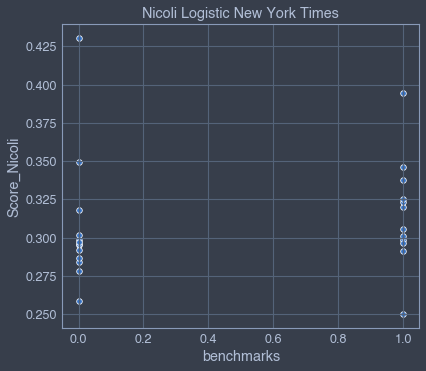

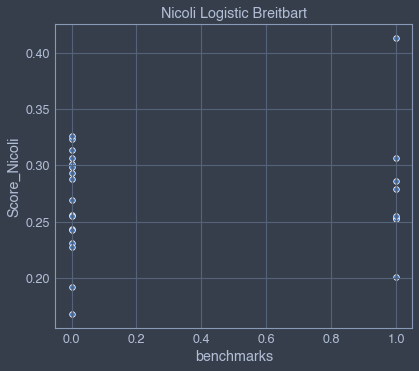

In [172]:
# Plot the results
for name, df in DFs_bench.items():
    sns.scatterplot(x = "benchmarks", 
                    y = "Score_Nicoli", 
                    data = df)
    plt.title("Nicoli Logistic "+str(name))
    plt.show()

### Average Score

In [195]:
for name, df in DFs_bench.items():
    print("\n\n###", name, "###")
    print("Average score for classified as subjective {:0.3f} ± {:0.3f}"
          .format(df[df['benchmarks'] == 1]['Score_Nicoli'].mean()[0], 
          df[df['benchmarks'] == 1]['Score_Nicoli'].std()/len(df)))
    print("Average score for classified as subjective {:0.3f} ± {:0.3f}"
          .format(df[df['benchmarks'] == 0]['Score_Nicoli'].mean()[0], 
          df[df['benchmarks'] == 0]['Score_Nicoli'].std()/len(df)))



### New York Times ###
Average score for classified as subjective 0.316 ± 0.001
Average score for classified as subjective 0.307 ± 0.002


### Breitbart ###
Average score for classified as subjective 0.281 ± 0.002
Average score for classified as subjective 0.267 ± 0.002
